In [1]:
# --- PyTorch
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
# --- NetworkX
import networkx as nx
# --- RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
# --- Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# --- Modules from local files
from GNN import GNN
from dataset import XASMolDataset
from utils.model import train_model, val_test, train_schnet, val_schnet
from utils.utils import plot_learning_curve

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'PyG version: {torch_geometric.__version__}')

Pytorch version: 2.4.1+cu124
PyG version: 2.5.3


#### Import dataset

In [3]:
# --- Path raw directory containing the data
path = "../"
dataset = XASMolDataset(path)
# --- Load and create the dataset
# dataset = torch.load('./processed/cor_pyg.pt')

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

In [4]:
# --- Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# --- Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

#torch.save(dataset, './processed/test_cor_pyg.pt')

XASMolDataset(317)
------------
Number of graphs: 317
Number of features: 15
Number of classes: 0

Data(x=[27, 15], edge_index=[2, 72], edge_attr=[72, 5], spectrum=[200], idx=[1], smiles='c12[c:4]3[c:6]4[c:7]([H:29])[c:9]([H:30])[c:10]5[c:8]3[c:12]3[c:16]6[c:20]1[C:22]1([C:21]([H:36])=[C:19]([H:37])[C:18]6=[C:17]([H:40])[C:15]([H:38])([H:39])[C:14]36[C:13]([H:32])([C:11]5([H:31])[H:35])[O:26]6)[C:23]([H:33])([C:1]([H:27])([H:34])[C:2]23[C:3]([H:28])([C:5]4([H:41])[H:42])[O:24]3)[O:25]1')
------------
Number of nodes: 27
Number of edges: 72
Average node degree: 2.67
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

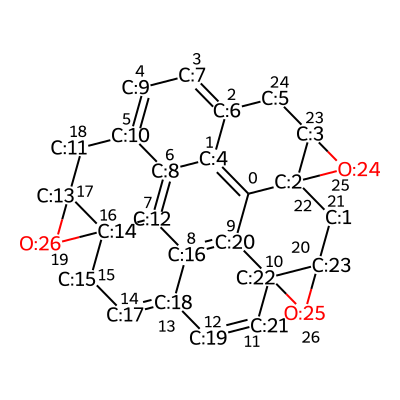

In [5]:
# --- View molecule using RDKit
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
mol = Chem.MolFromSmiles(data.smiles)
mol

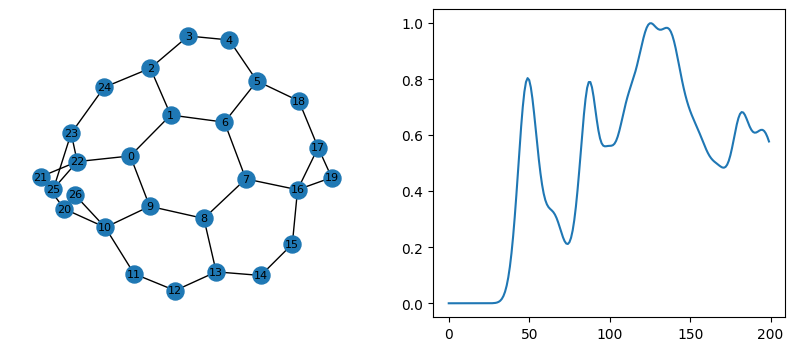

In [6]:
# --- Create subplot for plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# --- Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)
nx.draw(mol_graph, ax=ax1, with_labels=True, node_size=150, font_size=8)

# --- Show molecule spectrum
ax2.plot(data.spectrum)
plt.show()

#### Split up dataset

In [7]:
# --- Split data into test, validation and test
train_dataset = dataset[0:237]
val_dataset = dataset[237:277]
test_dataset = dataset[277:317]

# --- Pass into dataloader
train_loader = DataLoader(train_dataset, batch_size=237, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Length of training data loader: {len(train_loader.dataset)}, with a total of {len(train_loader)} datassets')
print(f'Length of validation data loader: {len(val_loader.dataset)}, with a total of {len(val_loader)} datasets')
# print(f'Length of testing data loader: {len(test_loader.dataset)}, with a total of {len(test_loader)} datasets')

Length of training data loader: 237, with a total of 1 datassets
Length of validation data loader: 40, with a total of 2 datasets


#### Set neural network properties

##### GNN

In [15]:
# --- Define parameters for GNN model
num_tasks = 200
num_layers = 3
in_channels = [dataset.num_features, 64, 128]
out_channels = [64, 128, 256]
gnn_type = "gcn"
heads = 1
drop_ratio = 0.3
graph_pooling = "mean"

In [16]:
# --- Select device to run model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# --- Set seed for model to allow for reproducibility
seed = 199
torch.manual_seed(seed)
# --- Create GNN model
model = GNN(
    num_tasks,
    num_layers,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
# --- View model details
print(model)
print('----')
print(f'Training will be performed on: {device} - {torch.cuda.get_device_name(0)}')

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(15, 64)
      (1): GCNConv(64, 128)
      (2): GCNConv(128, 256)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=256, out_features=200, bias=True)
)
----
Training will be performed on: cuda - NVIDIA GeForce RTX 4080


#### Model settings

In [17]:
# --- Set model optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
# --- Set optimizer scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [18]:
# -- Number of epochs for training
num_epochs = 500
# --- Empty list to store loss values
train_losses = []
val_losses = []

# --- Run model
for epoch in range(num_epochs):
    # --- Run a forward pass of the model
    loss = train_model(model, train_loader, optimizer, device) / len(train_loader)
    # --- Calculate validation error
    val_error = val_test(model, val_loader, device) / len(val_loader)
    # --- Apply scheduler
    scheduler.step(val_error)
    # --- Add losses to lists
    train_losses.append(loss)
    val_losses.append(val_error)
    # --- Get the current learing rate
    current_lr = optimizer.param_groups[0]["lr"]
    # --- Print out status of the model
    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:.3f}, TrainLoss: {loss:.5f}, ValLoss: {val_error:.5f}")

print('--------------')
print(f'Final training loss value of: {loss:.5f} and validation loss of: {val_error:.5f}')

Epoch: 000, LR: 0.010, TrainLoss: 0.25588, ValLoss: 0.28103
Epoch: 025, LR: 0.010, TrainLoss: 0.01942, ValLoss: 0.02326
Epoch: 050, LR: 0.010, TrainLoss: 0.01110, ValLoss: 0.01040
Epoch: 075, LR: 0.010, TrainLoss: 0.00967, ValLoss: 0.00848
Epoch: 100, LR: 0.010, TrainLoss: 0.00887, ValLoss: 0.00839
Epoch: 125, LR: 0.010, TrainLoss: 0.00815, ValLoss: 0.00798
Epoch: 150, LR: 0.010, TrainLoss: 0.00775, ValLoss: 0.00757
Epoch: 175, LR: 0.010, TrainLoss: 0.00759, ValLoss: 0.00879
Epoch: 200, LR: 0.010, TrainLoss: 0.00731, ValLoss: 0.00768
Epoch: 225, LR: 0.010, TrainLoss: 0.00718, ValLoss: 0.00790
Epoch: 250, LR: 0.010, TrainLoss: 0.00700, ValLoss: 0.00876
Epoch: 275, LR: 0.010, TrainLoss: 0.00703, ValLoss: 0.00869
Epoch: 300, LR: 0.010, TrainLoss: 0.00664, ValLoss: 0.00839
Epoch: 325, LR: 0.010, TrainLoss: 0.00661, ValLoss: 0.00835
Epoch: 350, LR: 0.010, TrainLoss: 0.00679, ValLoss: 0.00870
Epoch: 375, LR: 0.005, TrainLoss: 0.00641, ValLoss: 0.00714
Epoch: 400, LR: 0.005, TrainLoss: 0.0064

In [12]:
# # --- Save the model
# model_name = 'model_' + gnn_type + '_sd' + str(seed) + '.pt'
# torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

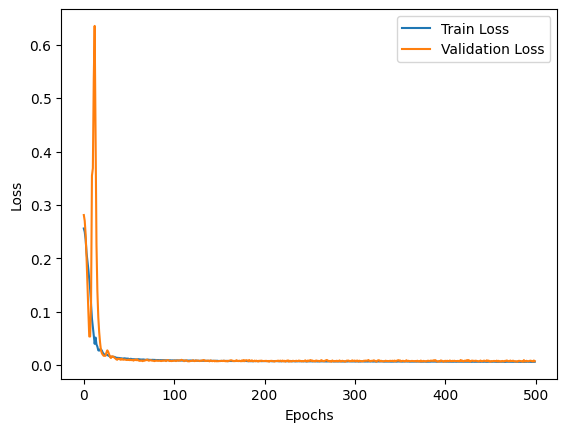

In [19]:
plot_learning_curve(num_epochs, train_losses, val_losses)

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE

trans = transform(n_components=3, perplexity=30, early_exaggeration=12, n_iter=1000)
x_reduced = trans.fit_transform(embedding.cpu().detach().numpy())
x_reduced.shape

NameError: name 'embedding' is not defined

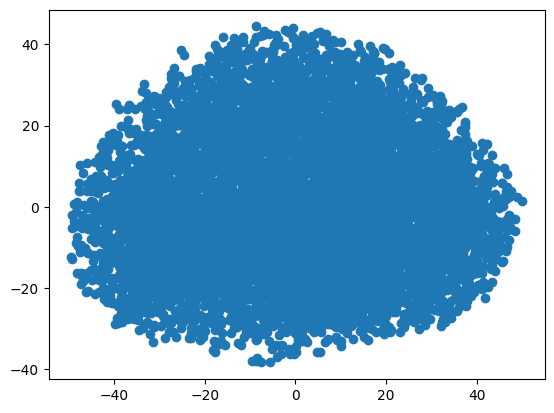

In [ ]:
plt.scatter(x_reduced[:,0], x_reduced[:,1])
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca_fit = pca.fit(embedding.cpu().detach().numpy())

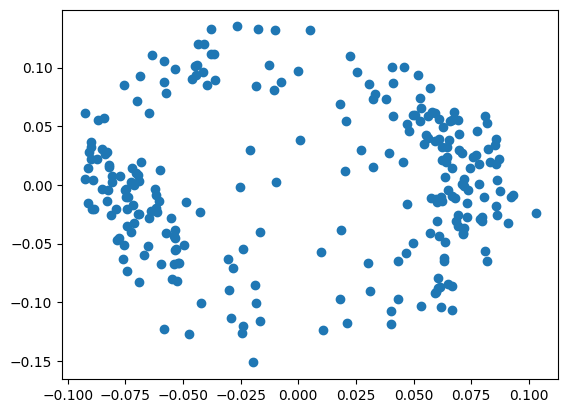

In [ ]:
plt.scatter(pca_fit.components_[0], pca_fit.components_[1])
plt.show()